In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
import numpy as np

# Tratamento de Dados

In [3]:
# Arquivo Excel
file_path = r'C:\Users\Salvador\Desktop\Afonso\Tese\Dados\ISEG_Bloomberg\Dados.xlsx'

In [4]:
# Função para ler e limpar dados de uma folha específica, tratando colunas extras
def read_sheet(sheet_name, col_name):
    data = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=6)
    data = data.iloc[:, [0, 1]]  # Seleciona apenas as duas primeiras colunas relevantes
    data.columns = ['Date', col_name]
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data = data.dropna().set_index('Date')
    data = data.shift(1).dropna()  # Desloca os preços uma linha para baixo
    return data

In [5]:
# Ler os dados das várias folhas com os nomes das colunas corrigidos
wti_data = read_sheet('WTI Crude Oil', 'WTI Crude Oil Prices')
sp500_data = read_sheet('S&P500', 'S&P500')
gold_data = read_sheet('Gold', 'Gold')
silver_data = read_sheet('Silver', 'Silver')
brent_data = read_sheet('Brent', 'Brent')
eurusd_data = read_sheet('EURUSD', 'EUR/USD')
eurrub_data = read_sheet('EURRUB', 'EUR/RUB')

In [6]:
# Combinar todas as folhas em um único DataFrame
combined_data = wti_data.join([sp500_data, gold_data, silver_data, brent_data, eurusd_data, eurrub_data], how='outer')
combined_data.dropna(inplace=True)

## Criação da var Monthly Price Avg

In [7]:
# Criar variável dependente: média das cotações mensais
combined_data['Monthly Average'] = combined_data['WTI Crude Oil Prices'].resample('M').transform('mean')

## Closing Prices das variáveis

In [8]:
# Exibir os primeiros 5 registros
print(combined_data.head())

            WTI Crude Oil Prices  S&P500    Gold  Silver  Brent  EUR/USD  \
Date                                                                       
1994-01-04                 14.67  466.89  393.85    5.24  13.61   1.1246   
1994-01-05                 15.34  467.55  391.20    5.09  14.26   1.1252   
1994-01-06                 15.42  467.12  388.90    5.12  14.36   1.1252   
1994-01-07                 15.32  469.90  387.10    5.01  14.23   1.1293   
1994-01-10                 14.67  475.27  384.60    5.04  13.74   1.1269   

            EUR/RUB  Monthly Average  
Date                                  
1994-01-04   1.1088           15.052  
1994-01-05   1.1154           15.052  
1994-01-06   1.1189           15.052  
1994-01-07   1.1148           15.052  
1994-01-10   1.1305           15.052  


In [9]:
# Filtrar os dados entre as datas de 1994 e 2024
start_date = '1994-01-04'
end_date = '2024-07-15'
filtered_data = combined_data[(combined_data.index >= start_date) & (combined_data.index <= end_date)]

In [10]:
# Função para plotar cada variável
def plot_variable(data, variable_name):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data[variable_name], label=variable_name)
    plt.title(f'{variable_name} (1994 - 2024)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

## Gráficos das variáveis (1994 - 2024)

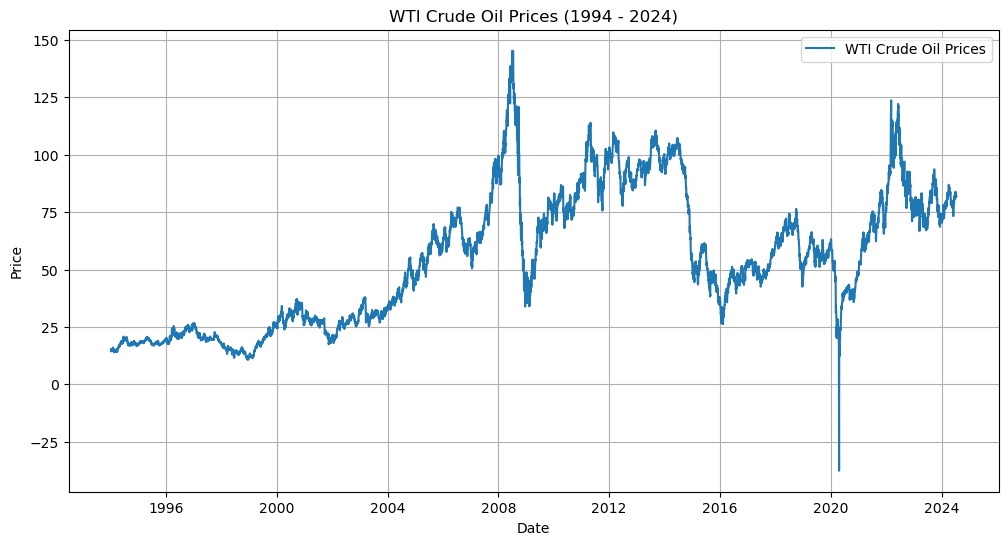

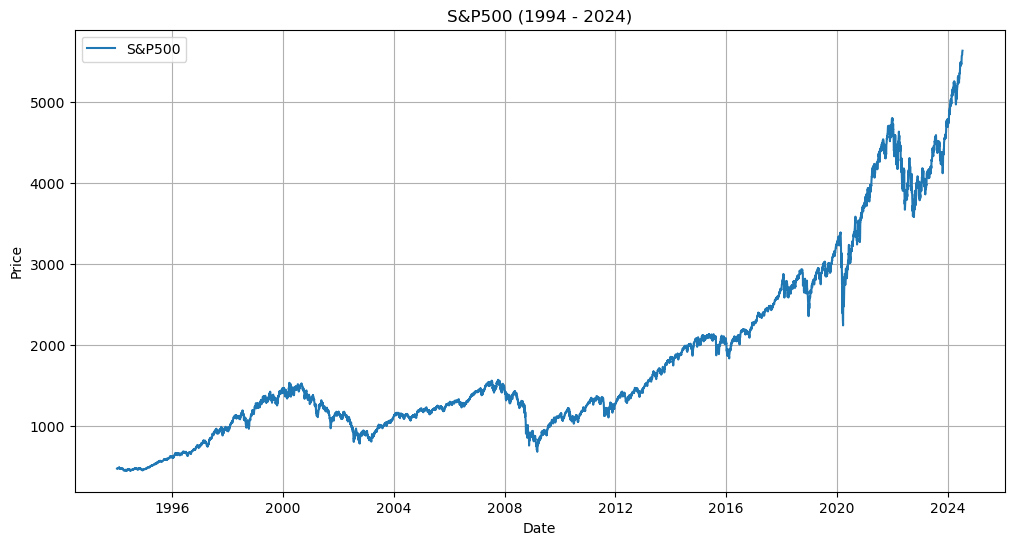

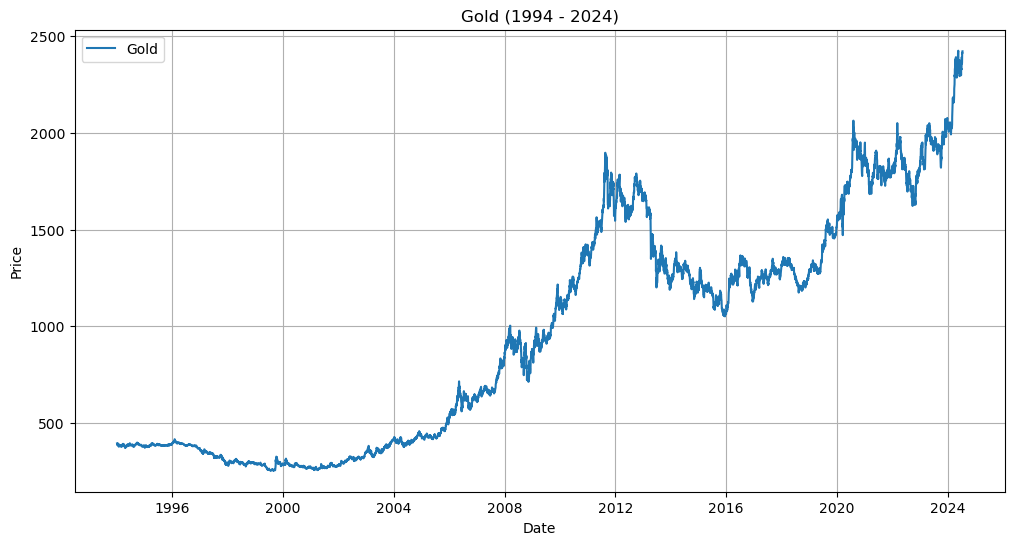

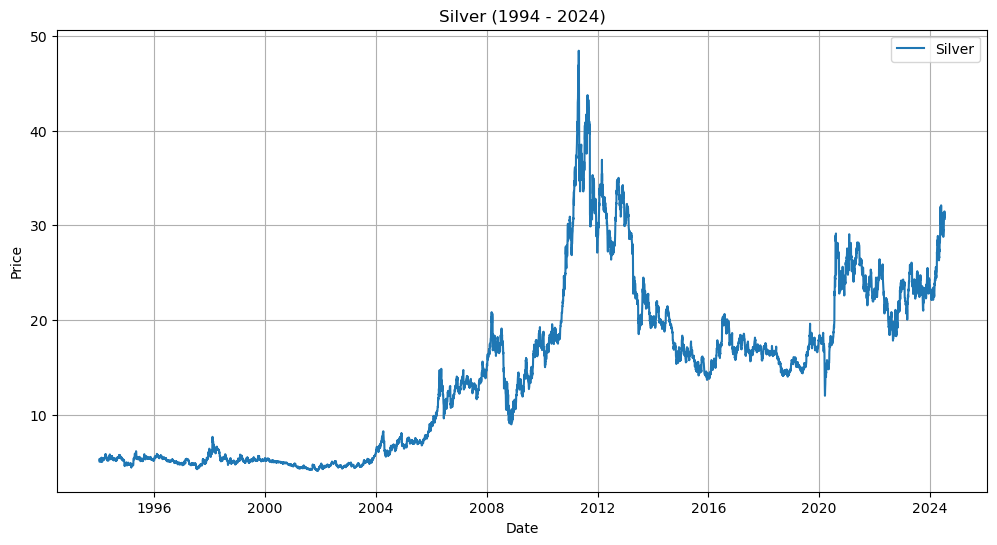

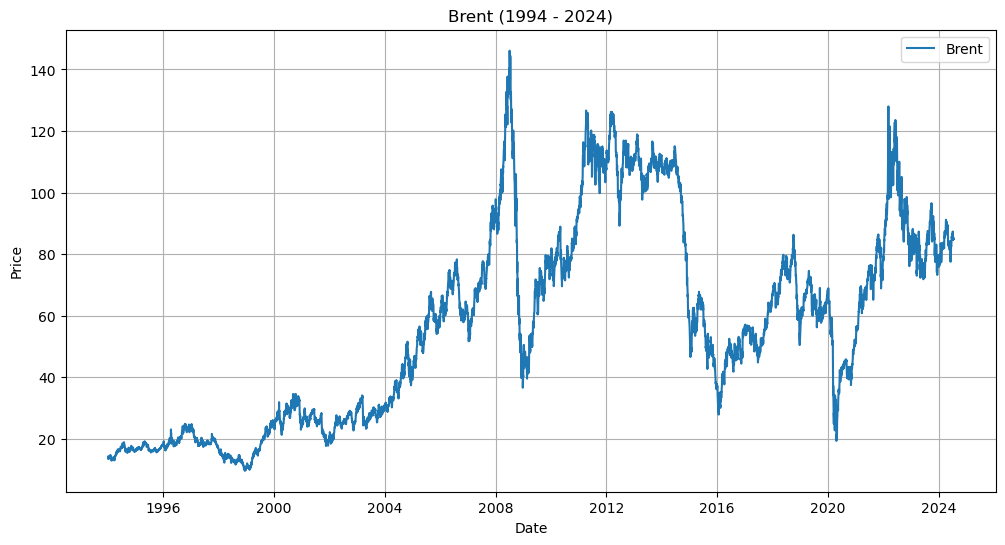

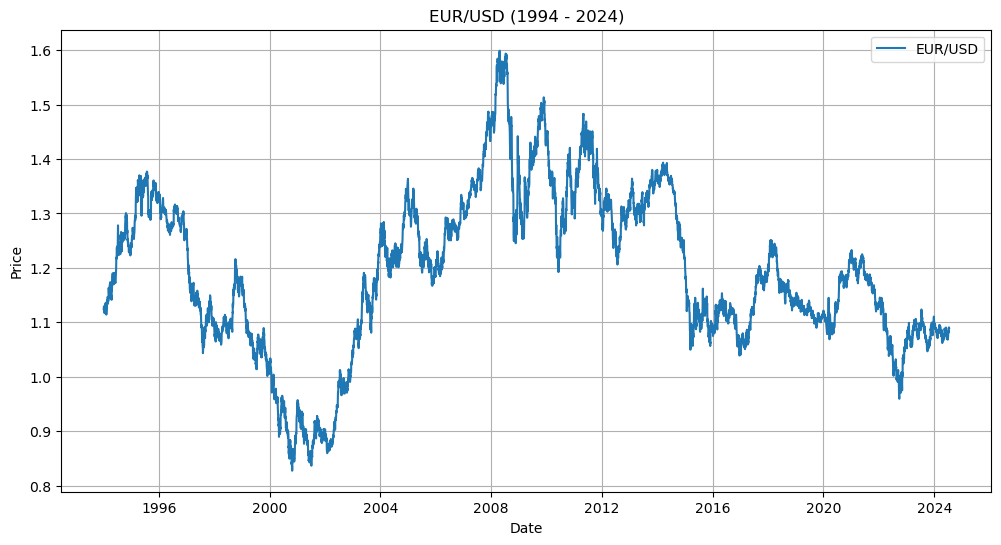

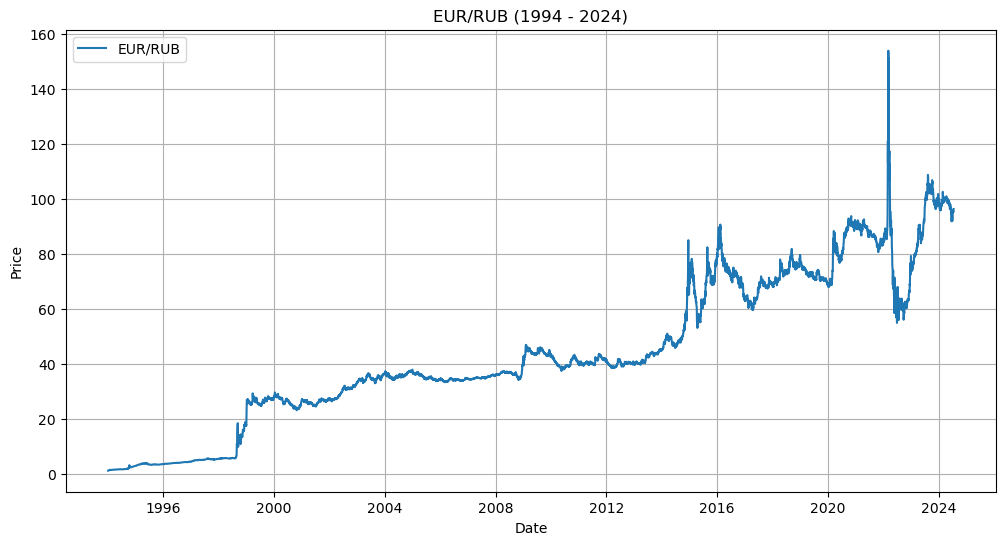

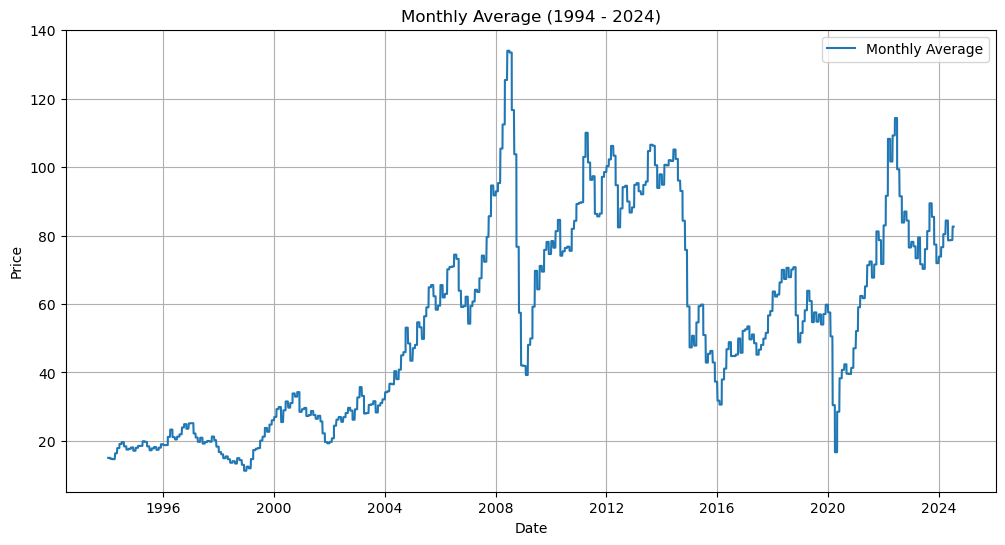

In [11]:
# Plotar gráficos para cada variável
variables = ['WTI Crude Oil Prices', 'S&P500', 'Gold', 'Silver', 'Brent', 'EUR/USD', 'EUR/RUB', 'Monthly Average']
for var in variables:
    plot_variable(filtered_data, var)

## Describe das 8 variáveis

In [12]:
# Descrever as variáveis
description = filtered_data.describe()
print(tabulate(description, headers='keys', tablefmt='psql'))

+-------+------------------------+----------+----------+------------+-----------+-------------+-----------+-------------------+
|       |   WTI Crude Oil Prices |   S&P500 |     Gold |     Silver |     Brent |     EUR/USD |   EUR/RUB |   Monthly Average |
|-------+------------------------+----------+----------+------------+-----------+-------------+-----------+-------------------|
| count |              7601      |  7601    | 7601     | 7601       | 7601      | 7601        | 7601      |         7601      |
| mean  |                54.9368 |  1809.75 |  963.887 |   14.3337  |   57.3906 |    1.19174  |   44.2331 |           54.9368 |
| std   |                29.1107 |  1146.46 |  587.178 |    8.81567 |   32.5277 |    0.147932 |   26.8983 |           29.0095 |
| min   |               -37.63   |   441.49 |  252.55  |    4.06    |    9.64   |    0.8272   |    1.1088 |           11.289  |
| 25%   |                27.63   |  1092.17 |  382.75  |    5.33    |   26.09   |    1.0922   |   27.333

## Heatmap do Dataset

In [13]:
# Calcular a matriz de correlação
correlation_matrix = filtered_data.corr()

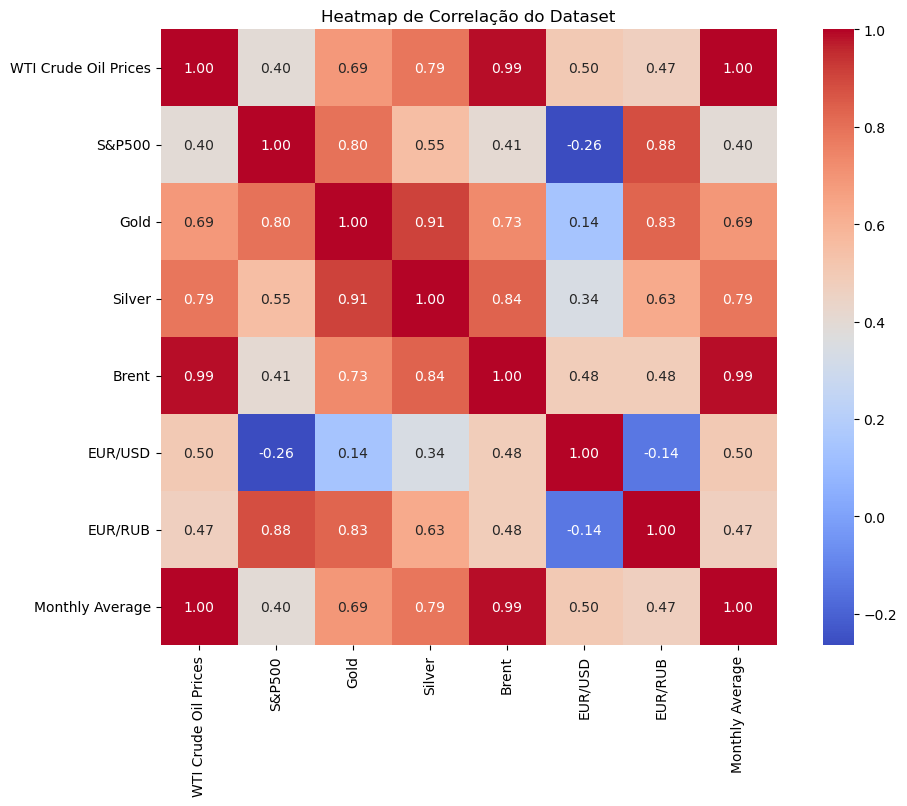

In [14]:
# Plotar o heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Heatmap de Correlação do Dataset')
plt.show()

# Modelagem

## Scaling dos dados

In [15]:
# Escalar os dados
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(filtered_data)

Falta verificar se o scaling está a ser feito no teste, porque não devemos limitar os dados de teste entre 0 e 1 já que não conhecemos os resultados ainda. Os resultados obtidos mais abaixo no código, têm presentes no eixo do y os valores entre 0 e 1.

## Variável dependente (monthly_price_avg)

In [16]:
# Função para criar features e targets
def create_features_and_target(data, horizon_days, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size - horizon_days + 1):
        X.append(data[i:i+window_size].flatten())
        # Calcular a média das cotações para o mês corrente
        y.append(np.mean(data[i+window_size:i+window_size+horizon_days, 0]))  # O target é a média das cotações do mês corrente
    return np.array(X), np.array(y)

## Horizontes temporais

Mantiveram-se os horizontes temporais, ou seja, em h=1 e com uma window_size=30, se se quiser prever a média das cotações de jan no dia 1jan vou usar os dias 2 a 31 dez; para prever a média das cotações no dia 2jan uso os dias 3dez a 1 jan, e assim sucessivamente. 

Para h=7, se quiser prever a média das cotações de jan no dia 7jan, vou usar os dias 2 a 31dez; para prever a média das cotações de jan no dia 8jan vou usar os dias 3dez a 1jan, e assim sucessivamente.

O mesmo acontece para os outros horizontes temporais (h=14, h=21 e h=30).

In [17]:
# Criar features e targets para cada horizonte
horizons = [1, 7, 14, 21, 30]
features_targets = {}
for horizon in horizons:
    X, y = create_features_and_target(scaled_data, horizon, window_size=30)
    features_targets[horizon] = (X, y)

In [18]:
# Imprimir as formas das features e targets para verificação
for horizon, (X, y) in features_targets.items():
    print(f"Horizon: {horizon} days")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}\n")

Horizon: 1 days
X shape: (7571, 240)
y shape: (7571,)

Horizon: 7 days
X shape: (7565, 240)
y shape: (7565,)

Horizon: 14 days
X shape: (7558, 240)
y shape: (7558,)

Horizon: 21 days
X shape: (7551, 240)
y shape: (7551,)

Horizon: 30 days
X shape: (7542, 240)
y shape: (7542,)



## Train-Test Split

Como temos dados desde 1994 e, por isso, um horizonte de 30 anos, deu-se um ratio de 80/20. Neste caso, 20% desse ratio corresponde a 6 anos (2018-2024) para testar os modelos. Já temos também a função shuffle=False que não permite misturar os dados de treino com os de teste e, consequentemente, torna os resultados obtidos mais realistas

In [19]:
# Função para dividir os dados em conjuntos de treino e teste
def split_data(X, y, test_size=0.2):
    return train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)

In [20]:
# Dividir os dados para cada horizonte
split_data_dict = {}
for horizon in horizons:
    X, y = features_targets[horizon]
    split_data_dict[horizon] = split_data(X, y)

In [21]:
# Imprimir as formas dos conjuntos de treino e teste para verificação
for horizon, (X_train, X_test, y_train, y_test) in split_data_dict.items():
    print(f"Horizon: {horizon} days")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}\n")

Horizon: 1 days
X_train shape: (6056, 240)
X_test shape: (1515, 240)
y_train shape: (6056,)
y_test shape: (1515,)

Horizon: 7 days
X_train shape: (6052, 240)
X_test shape: (1513, 240)
y_train shape: (6052,)
y_test shape: (1513,)

Horizon: 14 days
X_train shape: (6046, 240)
X_test shape: (1512, 240)
y_train shape: (6046,)
y_test shape: (1512,)

Horizon: 21 days
X_train shape: (6040, 240)
X_test shape: (1511, 240)
y_train shape: (6040,)
y_test shape: (1511,)

Horizon: 30 days
X_train shape: (6033, 240)
X_test shape: (1509, 240)
y_train shape: (6033,)
y_test shape: (1509,)



## Métricas usadas (R^2, RMSE, MAPE e MSE)

In [22]:
# Função para treinar e avaliar um modelo de regressão
def train_evaluate_regression(model, X_train, X_test, y_train, y_test, horizon):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Horizon: {horizon} days")
    print(f"{model.__class__.__name__} RMSE: {rmse:.4f}")
    print(f"{model.__class__.__name__} MAPE: {mape:.4f}")
    print(f"{model.__class__.__name__} MSE: {mse:.4f}")
    print(f"{model.__class__.__name__} R²: {r2:.4f}\n")
    return model, y_pred

## Modelos de ML usados 

### Parametrização

In [23]:
# Treinar e avaliar os modelos para cada horizonte
models = [
    LinearRegression(),
    Ridge(max_iter=10000),  # Aumentar o número de iterações para Ridge
    Lasso(alpha=0.01, max_iter=10000),  # Aumentar o número de iterações para Lasso
    ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000),  # Aumentar o número de iterações para ElasticNet
    RandomForestRegressor(),
    XGBRegressor(),
    SVR(kernel='rbf')
]

In [24]:
model_names = [
    "Linear Regression",
    "Ridge Regression",
    "Lasso Regression",
    "Elastic Net Regression",
    "Random Forest Regression",
    "XGBRegressor",
    "SVR"
]

# Resultados

In [25]:
results = {name: {} for name in model_names}
for horizon in horizons:
    X_train, X_test, y_train, y_test = split_data_dict[horizon]
    for model, name in zip(models, model_names):
        trained_model, y_pred = train_evaluate_regression(model, X_train, X_test, y_train, y_test, horizon)
        results[name][horizon] = {
            "RMSE": mean_squared_error(y_test, y_pred, squared=False),
            "MAPE": mean_absolute_percentage_error(y_test, y_pred),
            "MSE": mean_squared_error(y_test, y_pred),
            "R²": r2_score(y_test, y_pred),
            "y_pred": y_pred
        }

Horizon: 1 days
LinearRegression RMSE: 0.0137
LinearRegression MAPE: 886733493078.6548
LinearRegression MSE: 0.0002
LinearRegression R²: 0.9831

Horizon: 1 days
Ridge RMSE: 0.0132
Ridge MAPE: 903088912811.5941
Ridge MSE: 0.0002
Ridge R²: 0.9845

Horizon: 1 days
Lasso RMSE: 0.0386
Lasso MAPE: 1057181306602.8711
Lasso MSE: 0.0015
Lasso R²: 0.8663

Horizon: 1 days
ElasticNet RMSE: 0.0271
ElasticNet MAPE: 1013959157855.9136
ElasticNet MSE: 0.0007
ElasticNet R²: 0.9339

Horizon: 1 days
RandomForestRegressor RMSE: 0.0131
RandomForestRegressor MAPE: 908966444159.6704
RandomForestRegressor MSE: 0.0002
RandomForestRegressor R²: 0.9845

Horizon: 1 days
XGBRegressor RMSE: 0.0173
XGBRegressor MAPE: 927317281564.2384
XGBRegressor MSE: 0.0003
XGBRegressor R²: 0.9730

Horizon: 1 days
SVR RMSE: 0.0804
SVR MAPE: 1470936036725.9146
SVR MSE: 0.0065
SVR R²: 0.4202

Horizon: 7 days
LinearRegression RMSE: 0.0127
LinearRegression MAPE: 0.0150
LinearRegression MSE: 0.0002
LinearRegression R²: 0.9853

Horizon:

## Tabela c/ resultados

In [26]:
# Criar tabelas para cada horizonte
for horizon in horizons:
    table = [["Model", "RMSE", "MAPE", "MSE", "R²"]]
    for name in model_names:
        result = results[name][horizon]
        table.append([
            name,
            f"{result['RMSE']:.4f}",
            f"{result['MAPE']:.4f}",
            f"{result['MSE']:.4f}",
            f"{result['R²']:.4f}"
        ])
    print(f"\nResults for horizon: {horizon} days")
    print(tabulate(table, headers="firstrow", tablefmt="github"))


Results for horizon: 1 days
| Model                    |   RMSE |        MAPE |    MSE |     R² |
|--------------------------|--------|-------------|--------|--------|
| Linear Regression        | 0.0137 | 8.86733e+11 | 0.0002 | 0.9831 |
| Ridge Regression         | 0.0132 | 9.03089e+11 | 0.0002 | 0.9845 |
| Lasso Regression         | 0.0386 | 1.05718e+12 | 0.0015 | 0.8663 |
| Elastic Net Regression   | 0.0271 | 1.01396e+12 | 0.0007 | 0.9339 |
| Random Forest Regression | 0.0131 | 9.08966e+11 | 0.0002 | 0.9845 |
| XGBRegressor             | 0.0173 | 9.27317e+11 | 0.0003 | 0.973  |
| SVR                      | 0.0804 | 1.47094e+12 | 0.0065 | 0.4202 |

Results for horizon: 7 days
| Model                    |   RMSE |   MAPE |    MSE |     R² |
|--------------------------|--------|--------|--------|--------|
| Linear Regression        | 0.0127 | 0.015  | 0.0002 | 0.9853 |
| Ridge Regression         | 0.0133 | 0.0159 | 0.0002 | 0.9839 |
| Lasso Regression         | 0.0379 | 0.0504 | 0.001

In [27]:
# Função para plotar previsões vs valores reais
def plot_predictions(y_test, y_pred, model_name, horizon):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(y_test)), y_test, label='True', color='blue')
    plt.plot(range(len(y_test)), y_pred, label=model_name, color='orange')
    plt.title(f'Predição do modelo {model_name} para horizonte de {horizon} dias')
    plt.xlabel('Observations')
    plt.ylabel('WTI Crude Oil Prices')
    plt.legend()
    plt.grid(True)
    plt.show()

## Plotagem dos gráficos (True vs Previsão)

In [195]:
y_test

array([0.60993877, 0.61103215, 0.6044719 , ..., 0.65739121, 0.65514979,
       0.65350973])

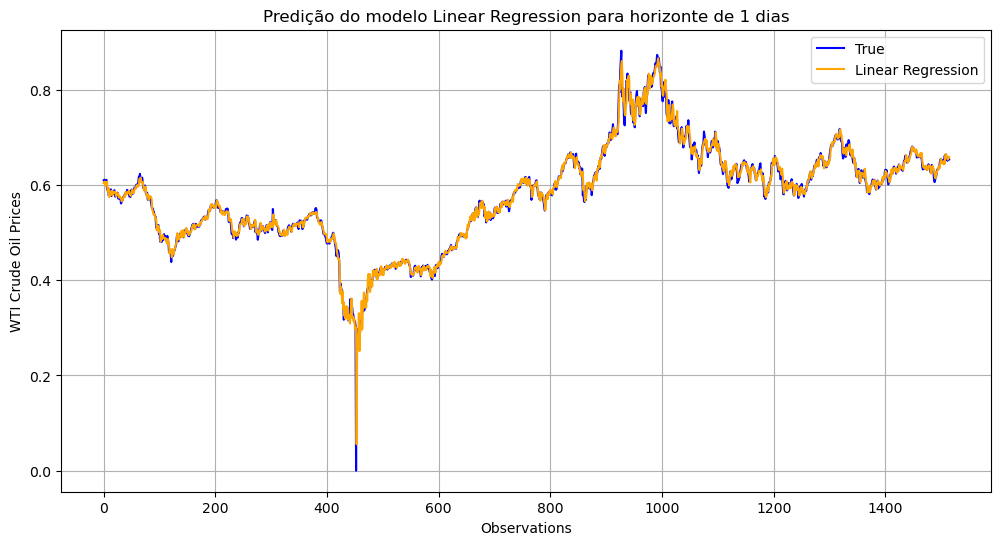

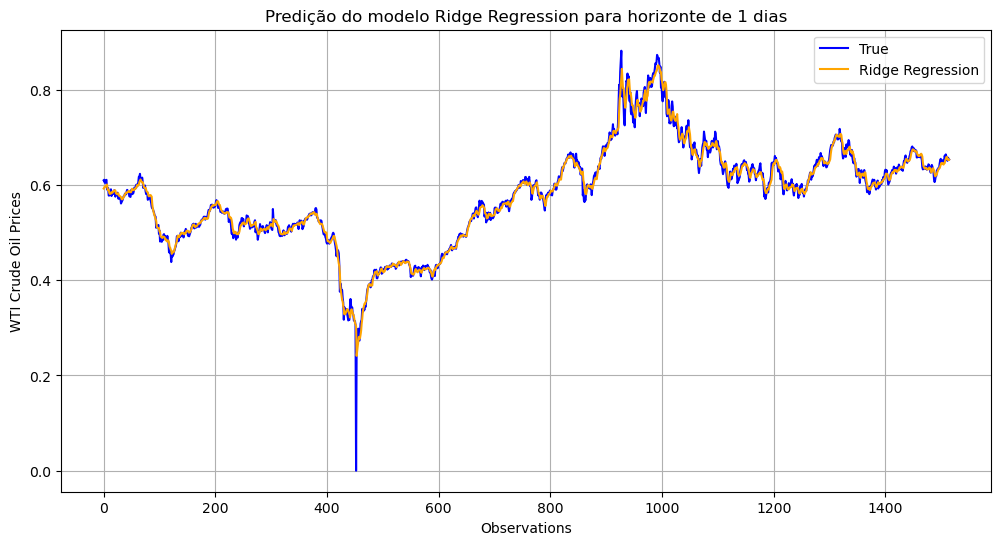

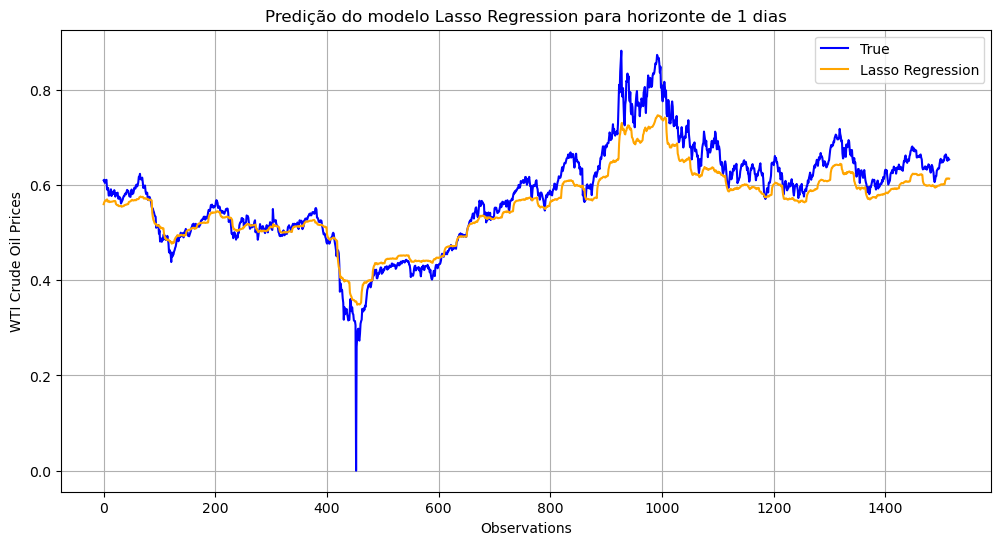

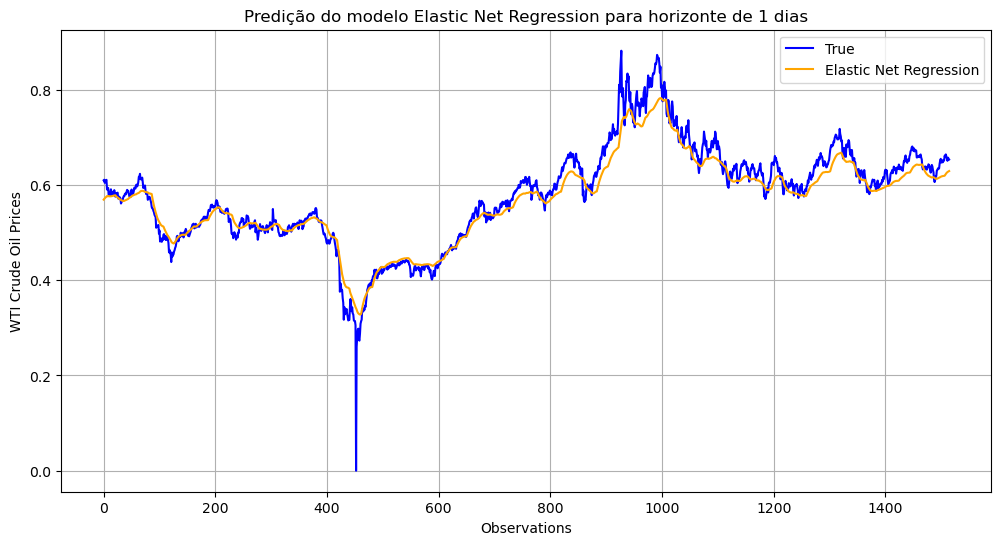

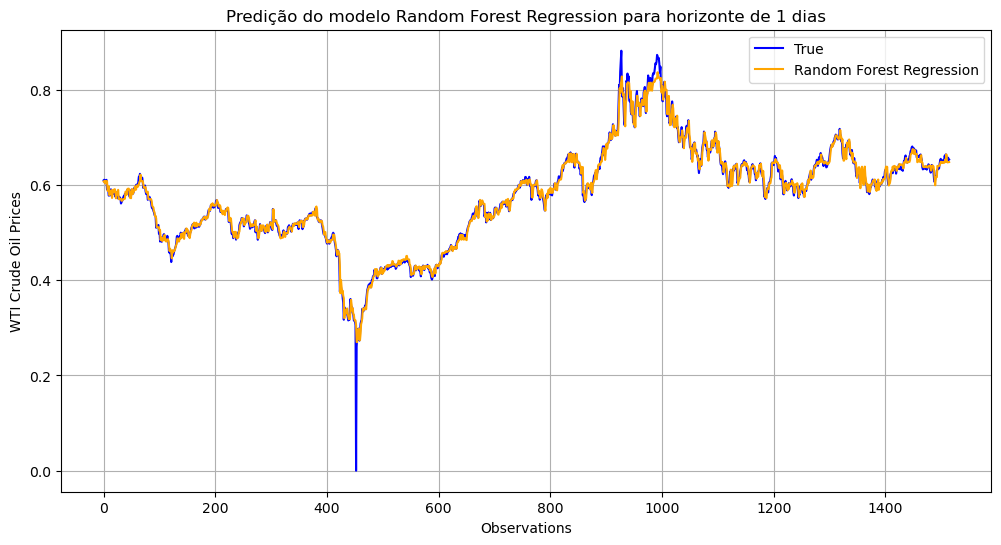

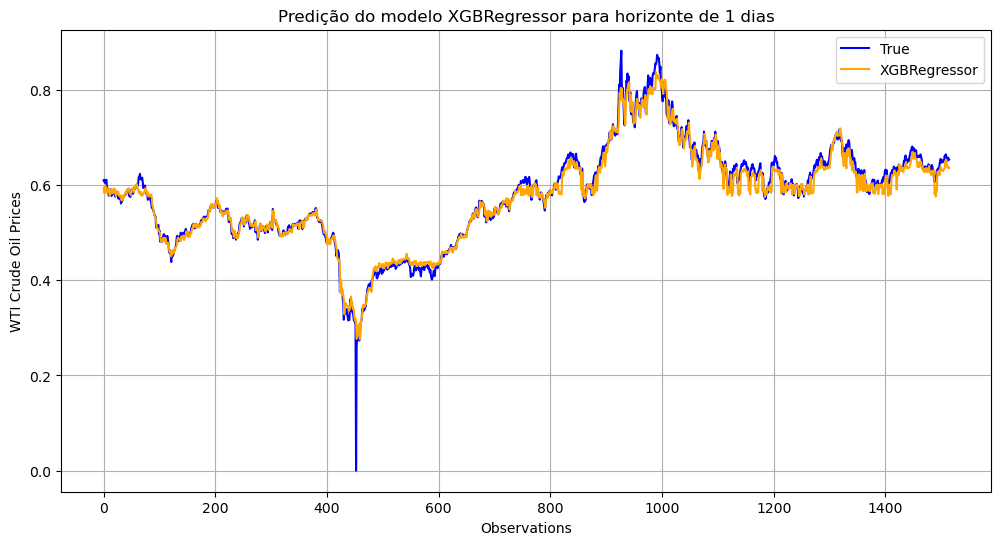

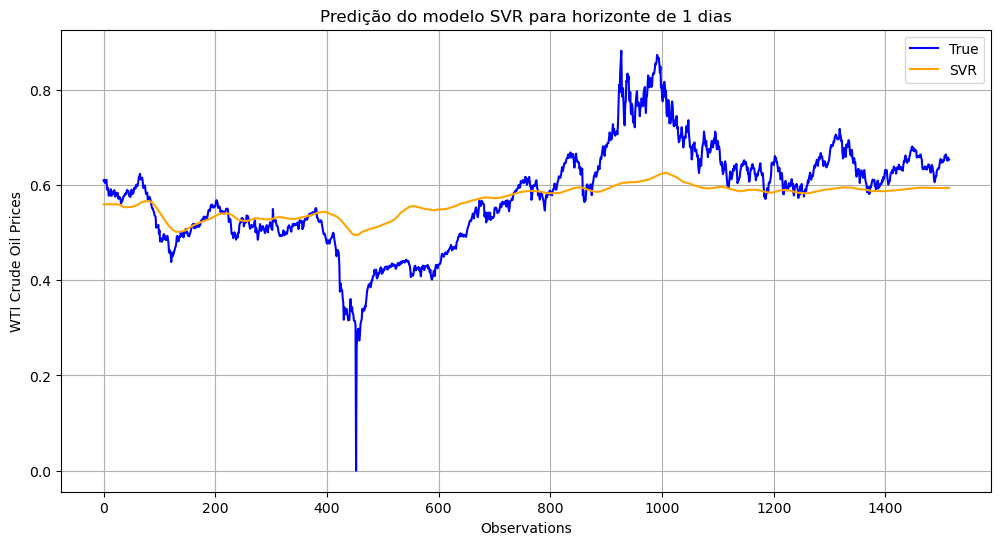

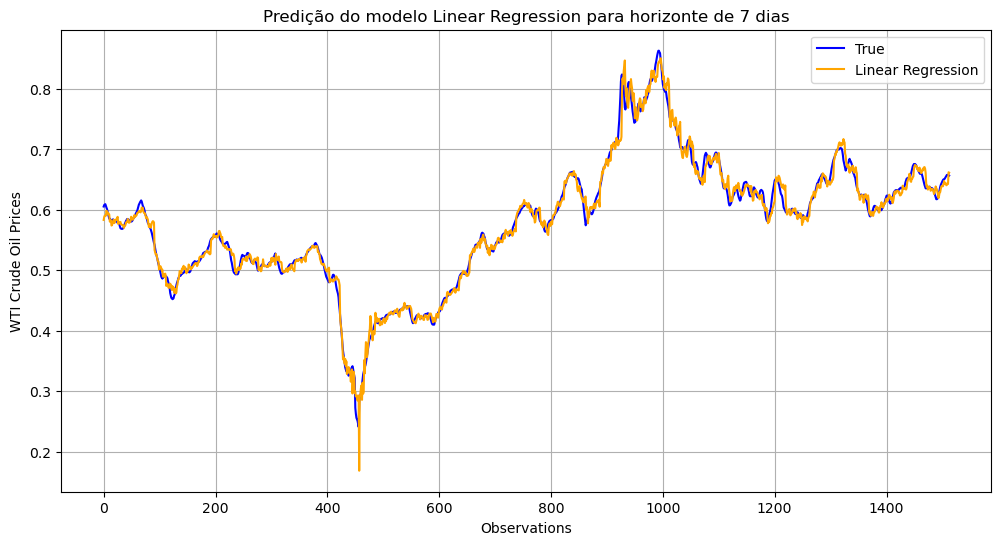

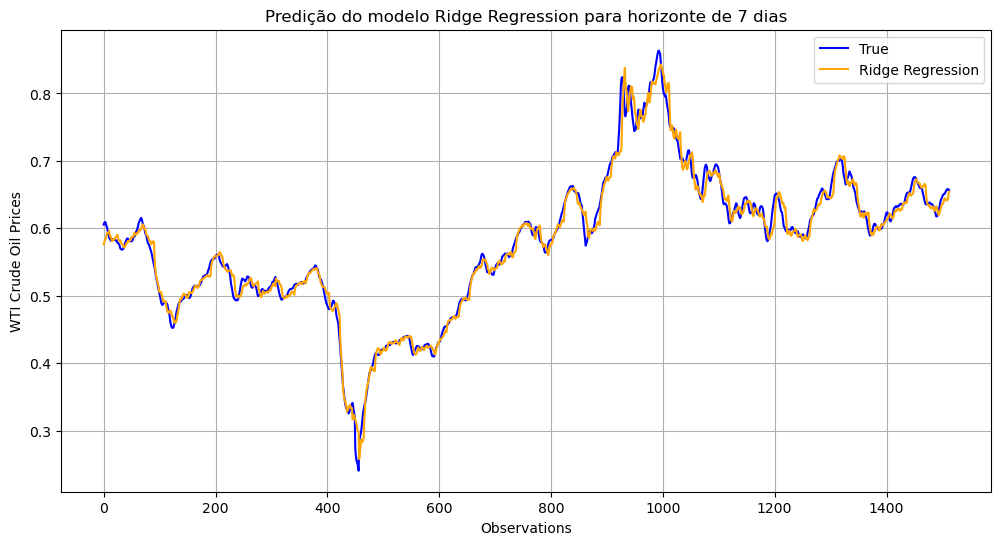

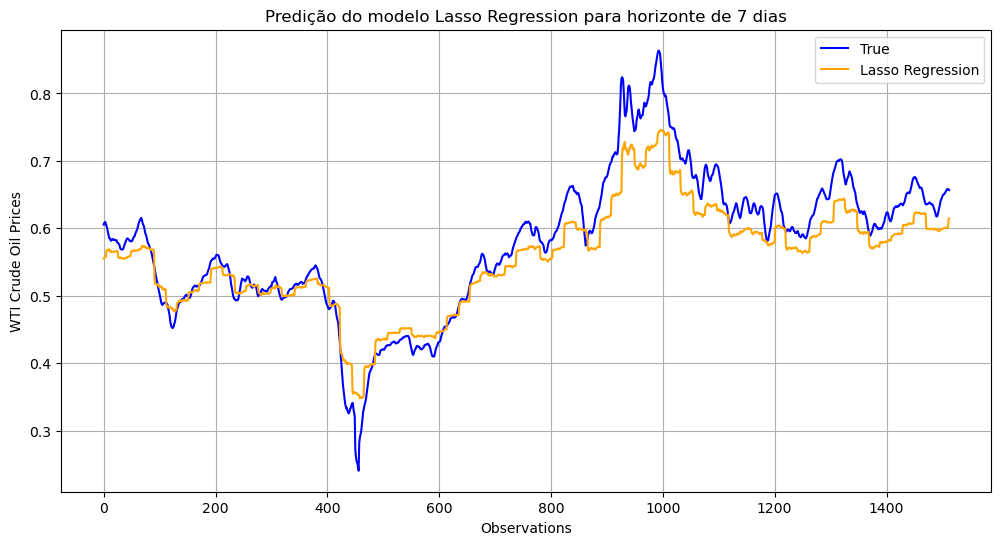

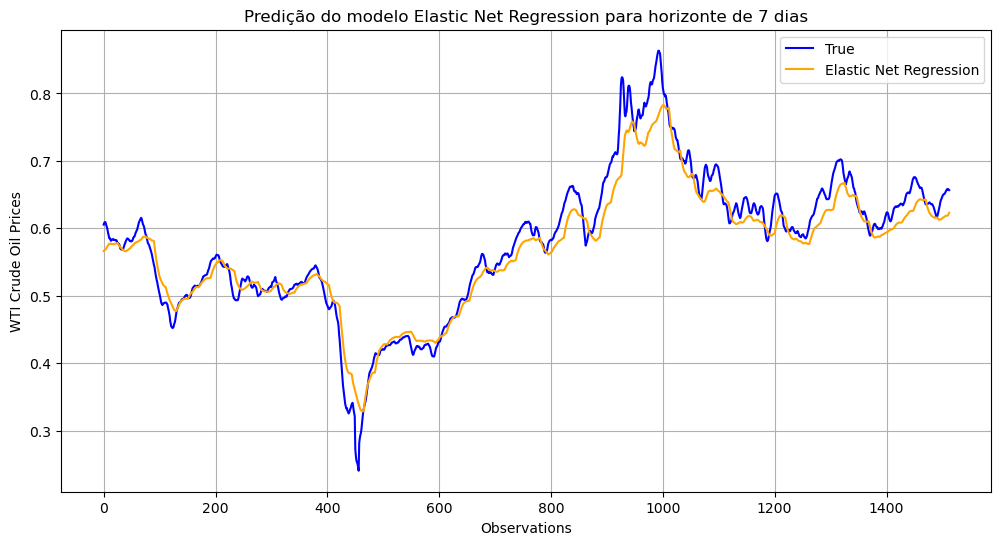

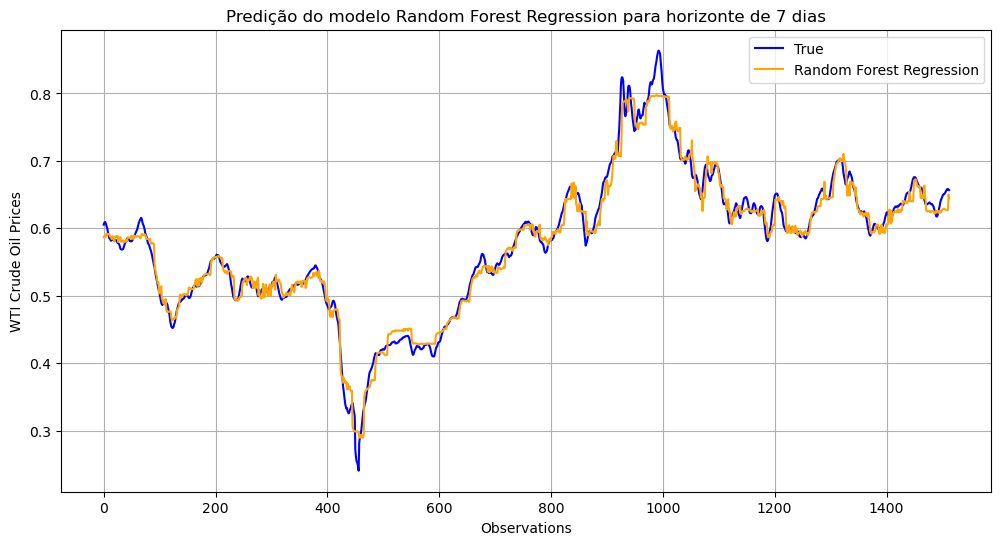

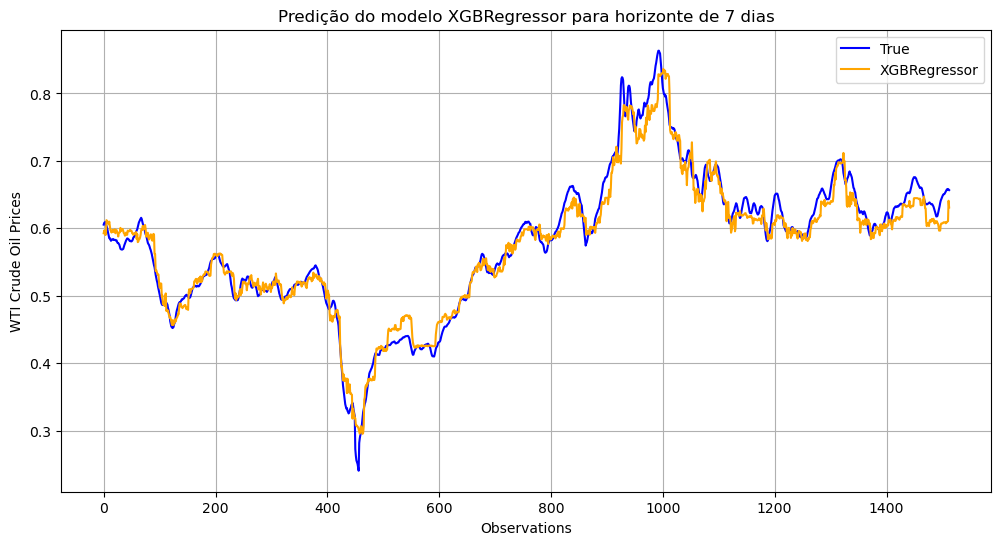

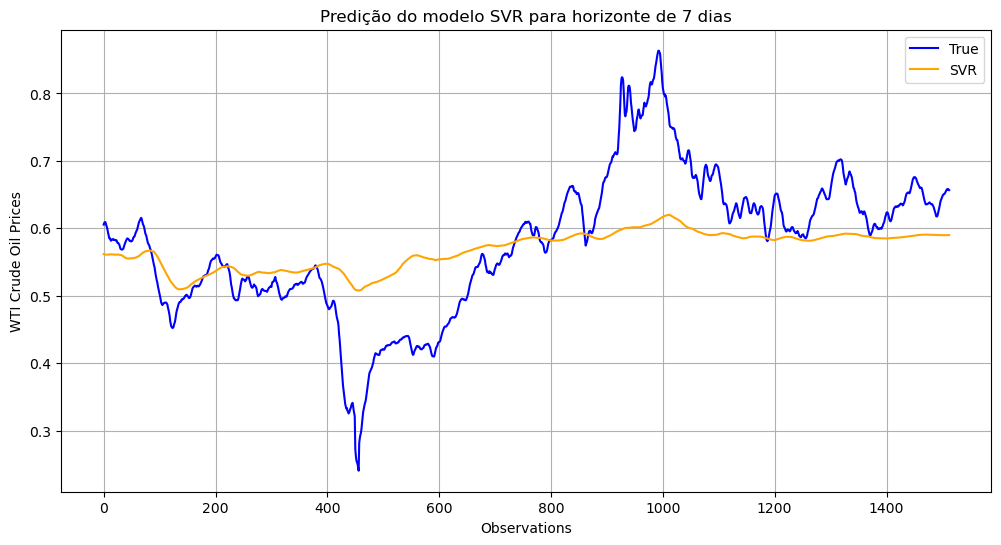

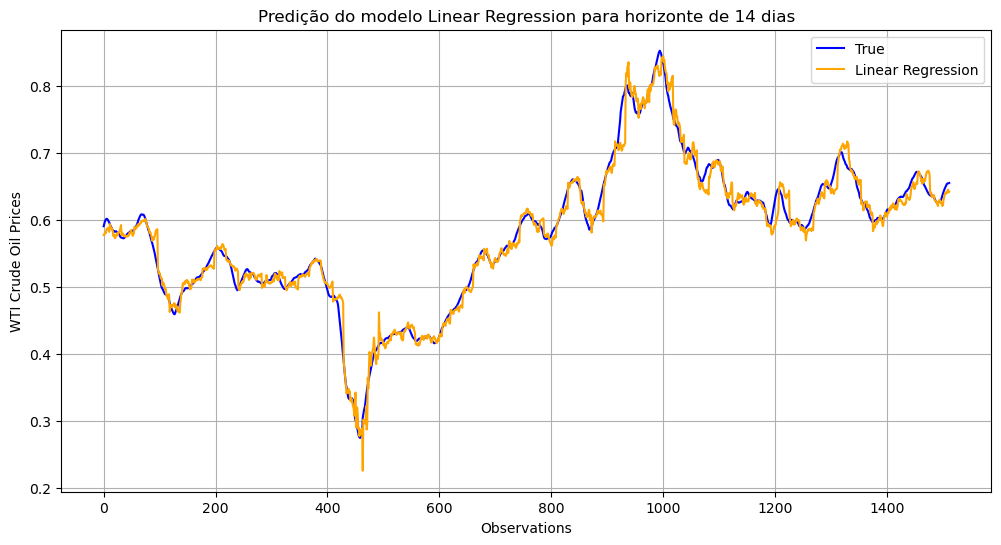

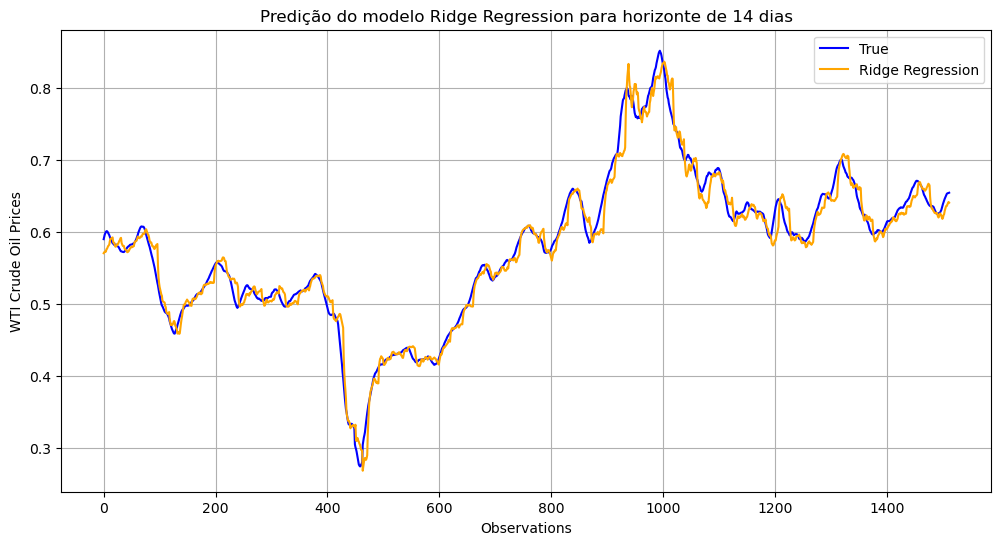

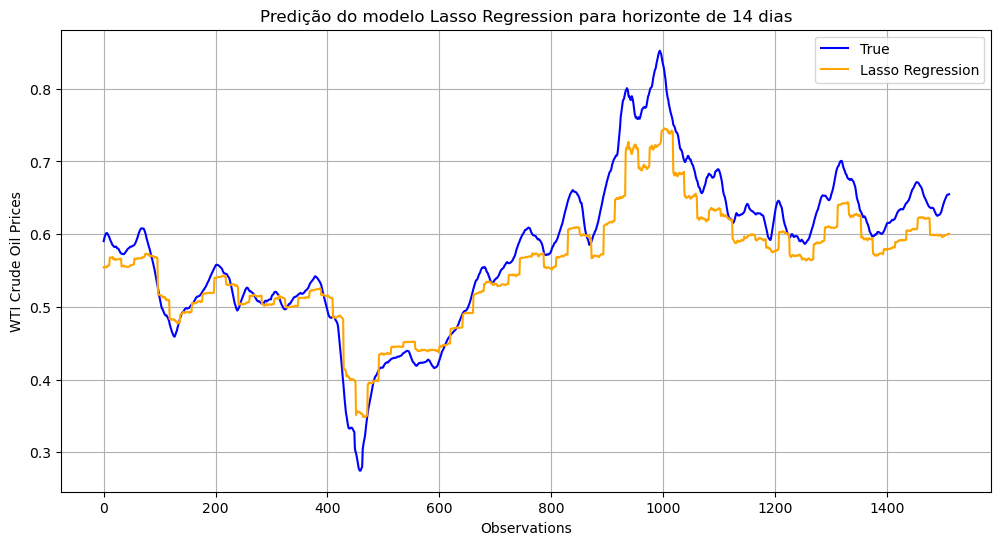

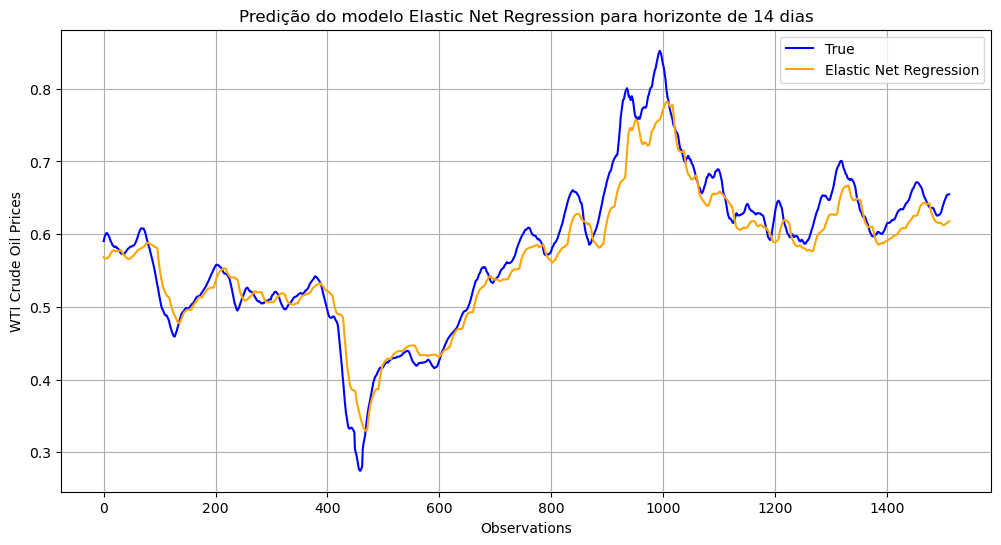

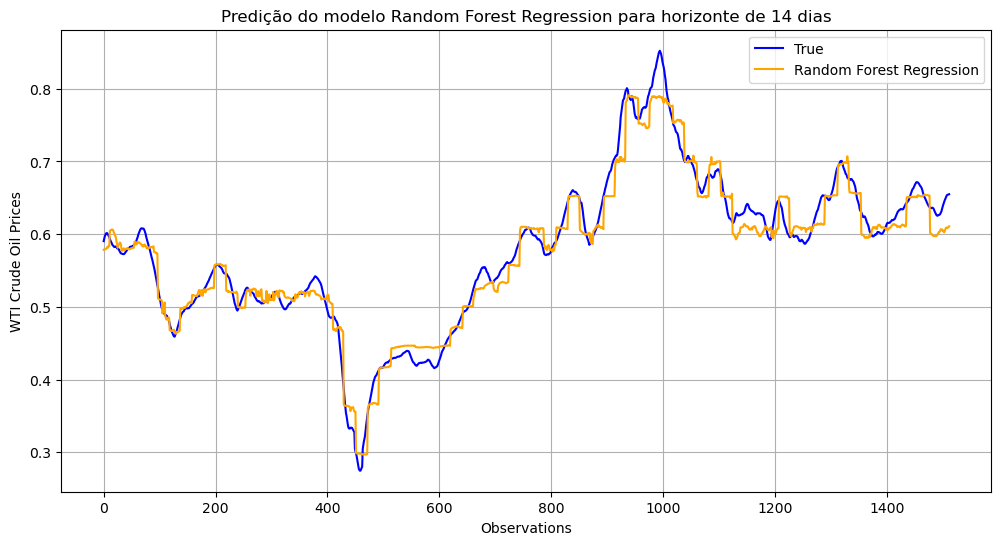

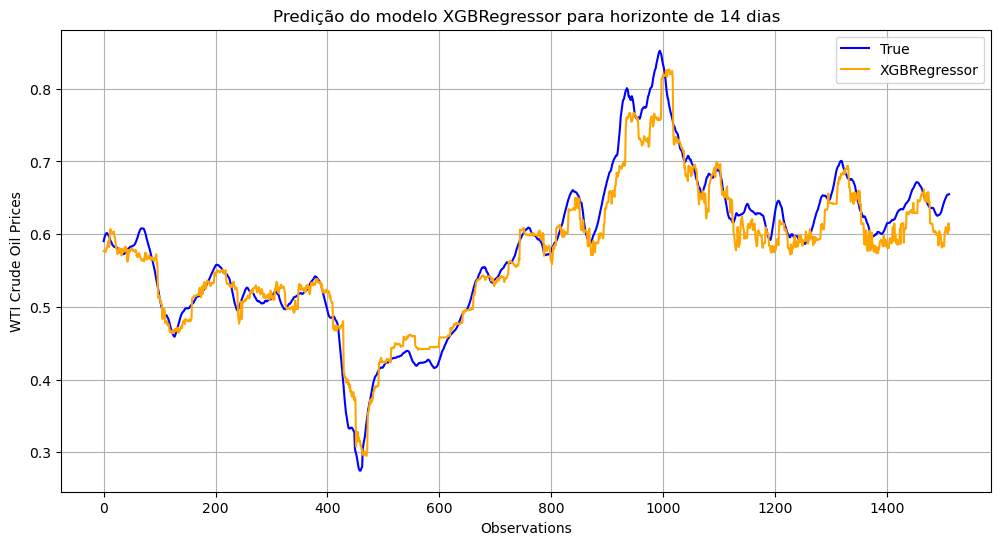

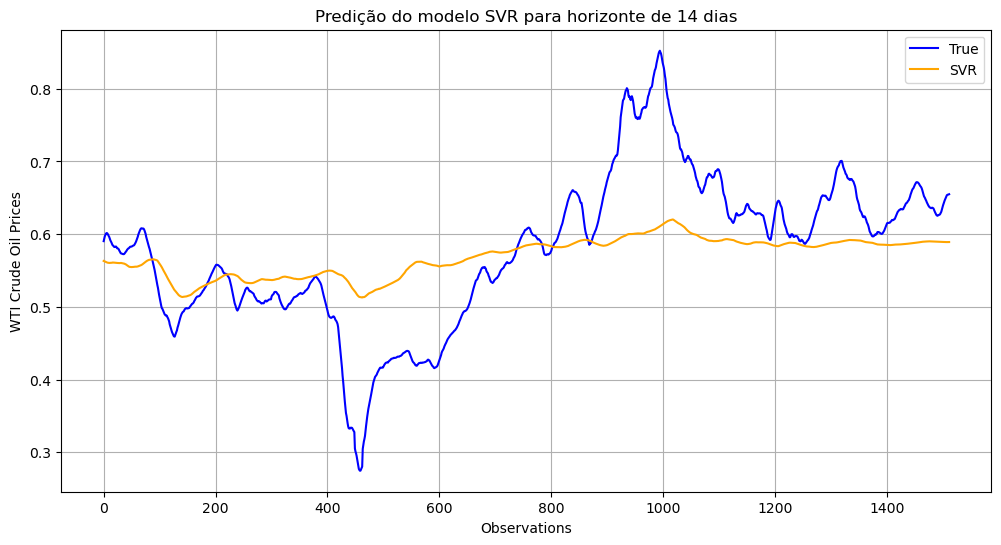

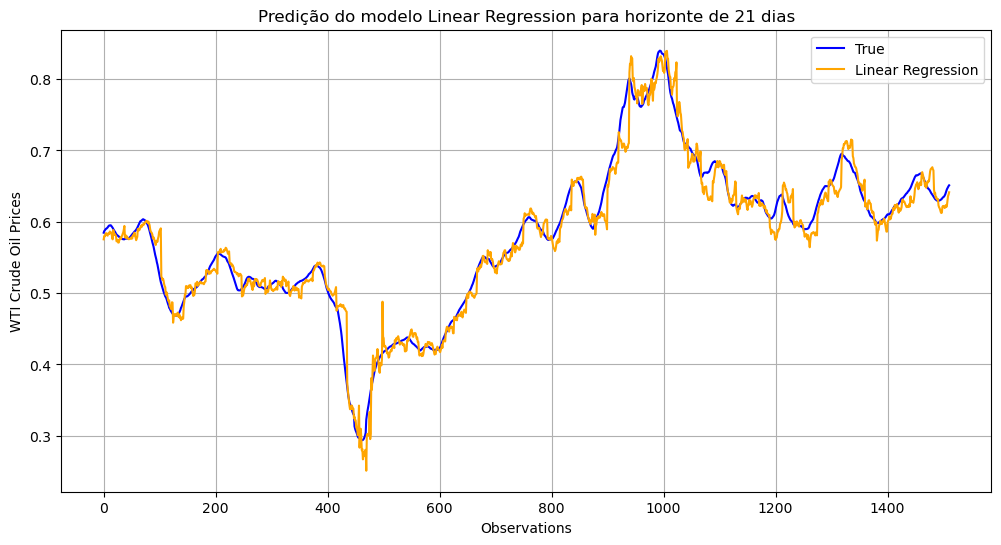

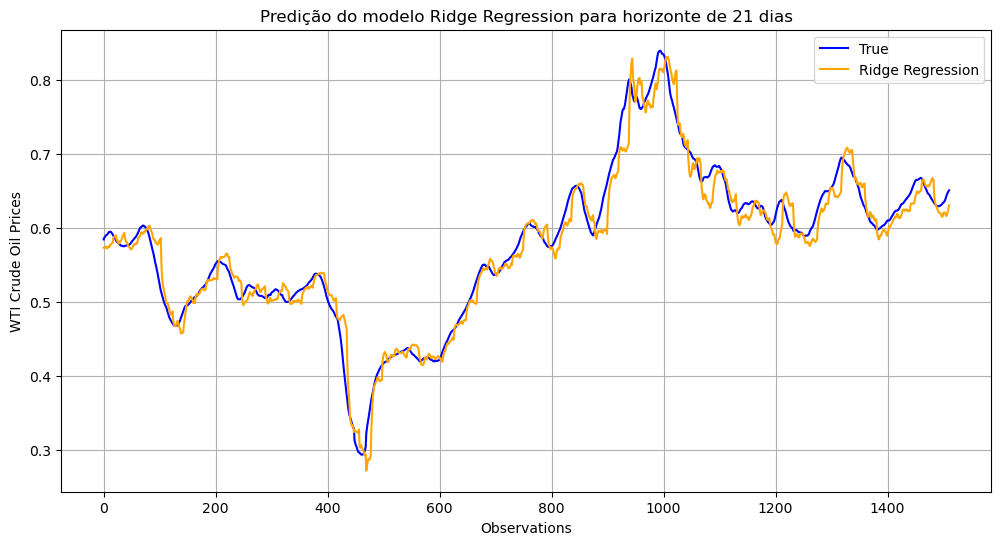

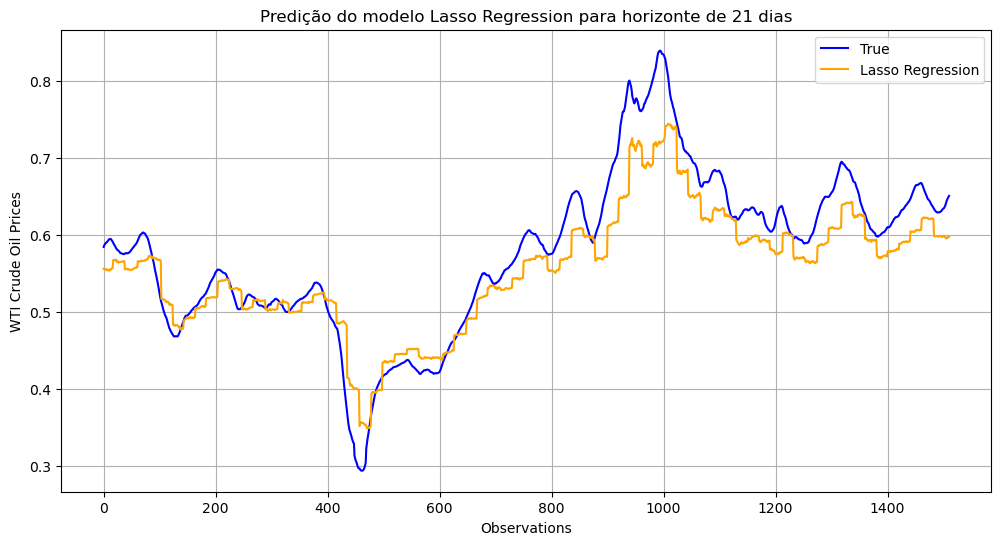

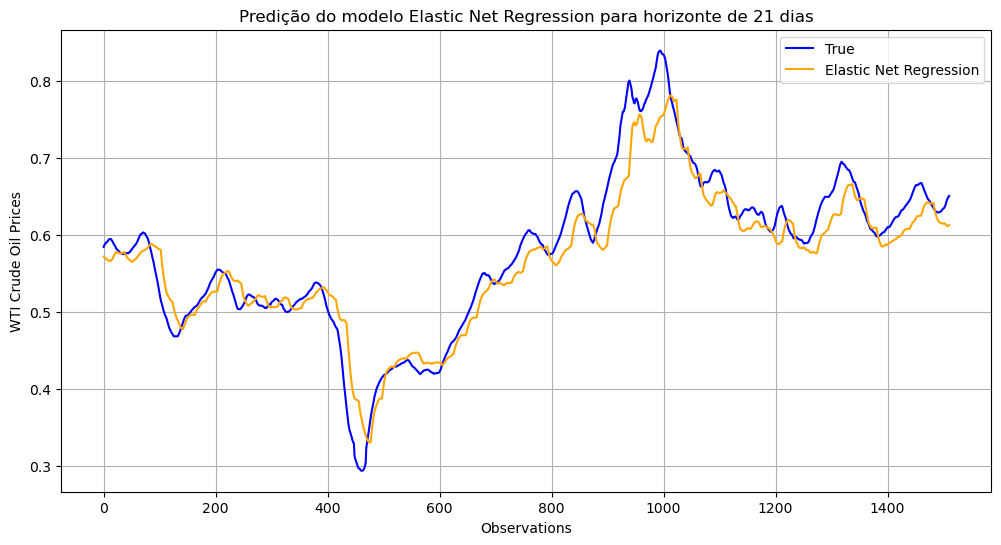

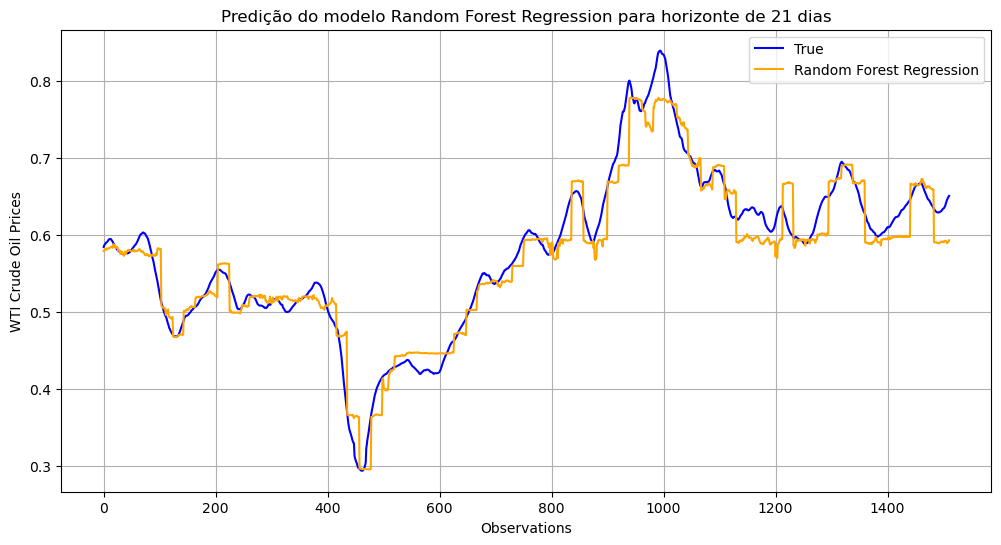

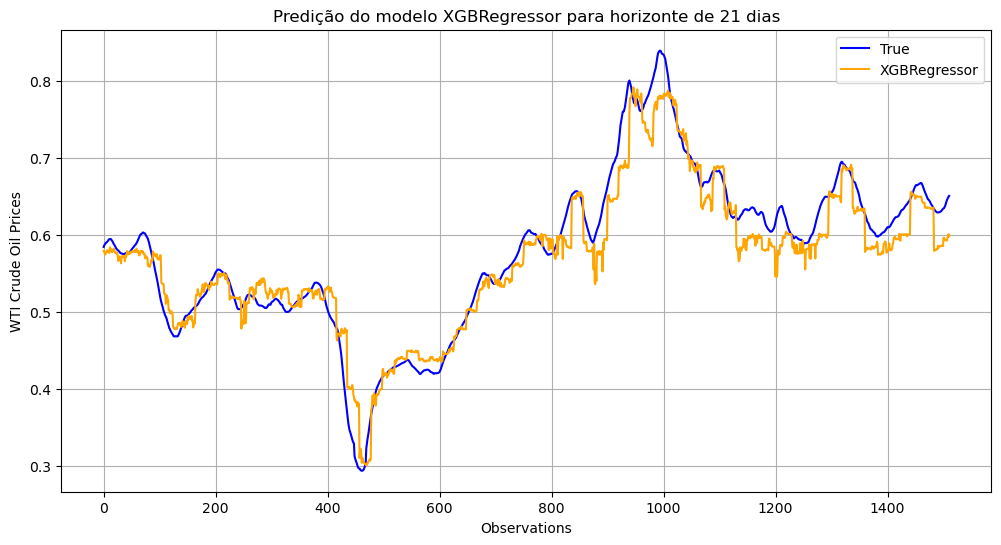

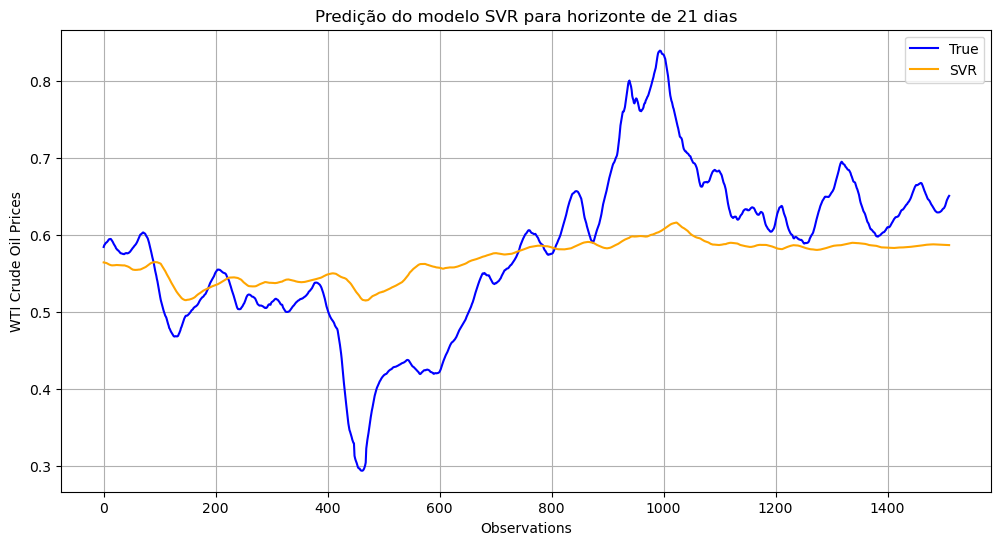

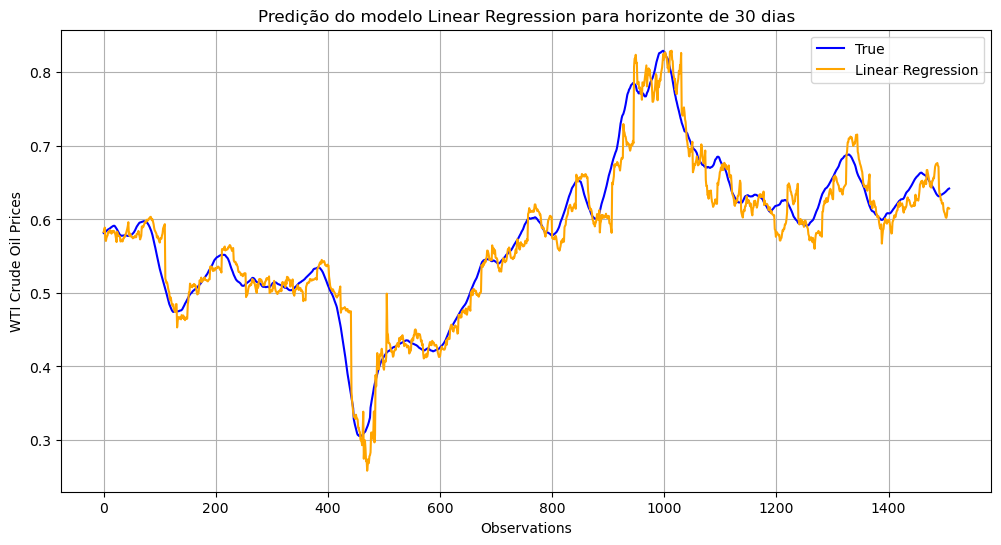

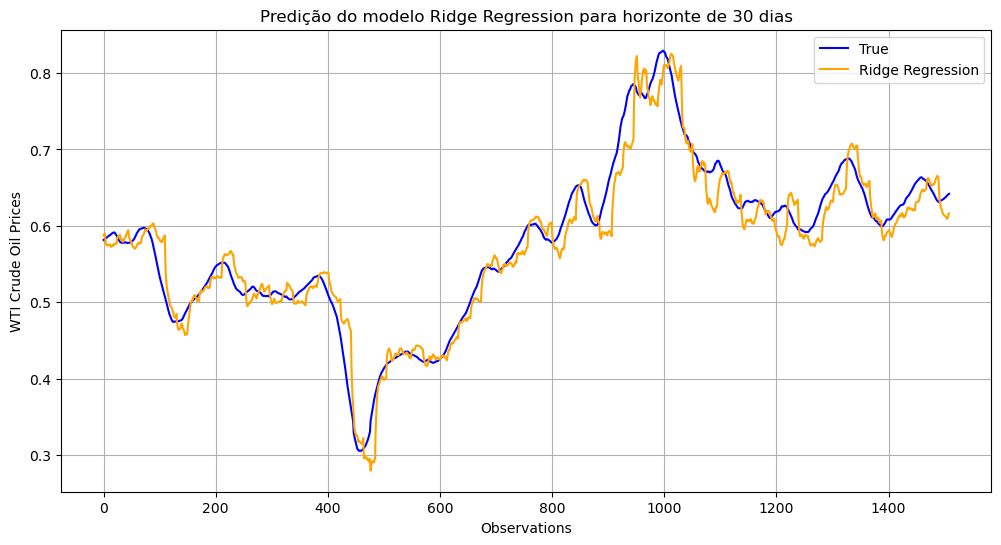

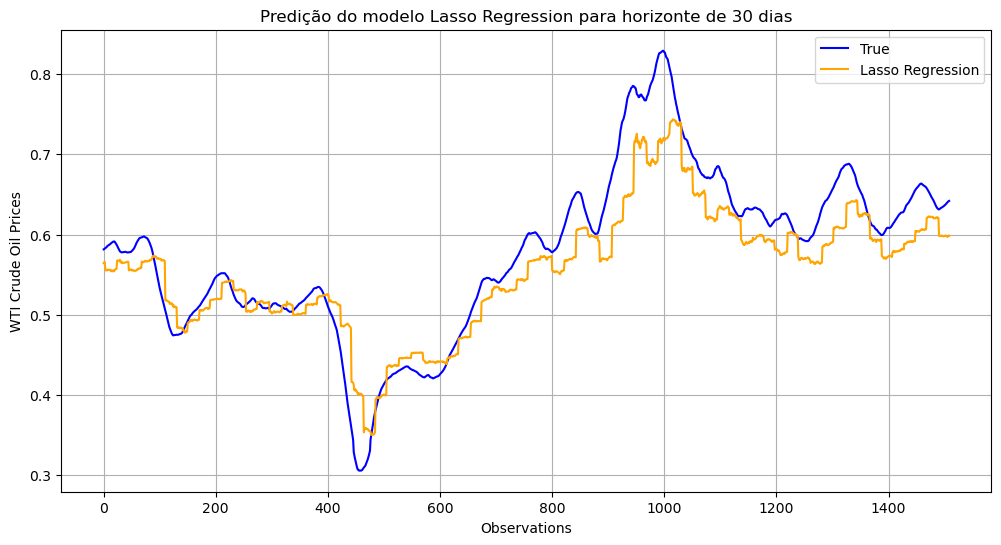

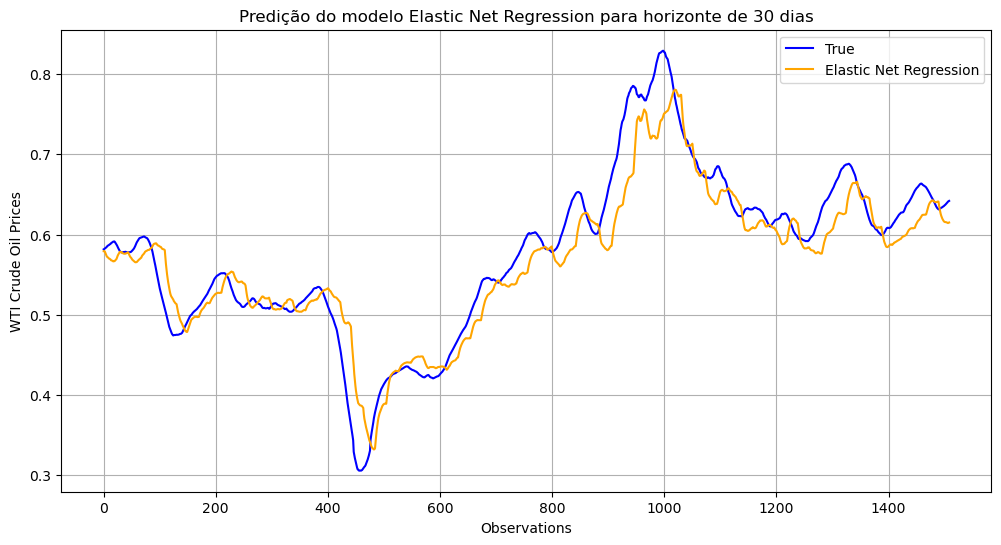

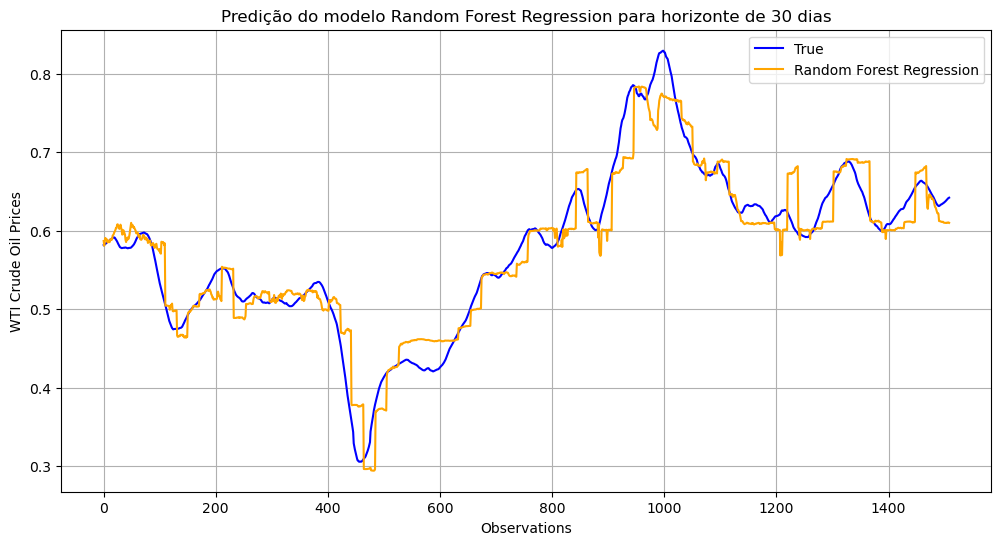

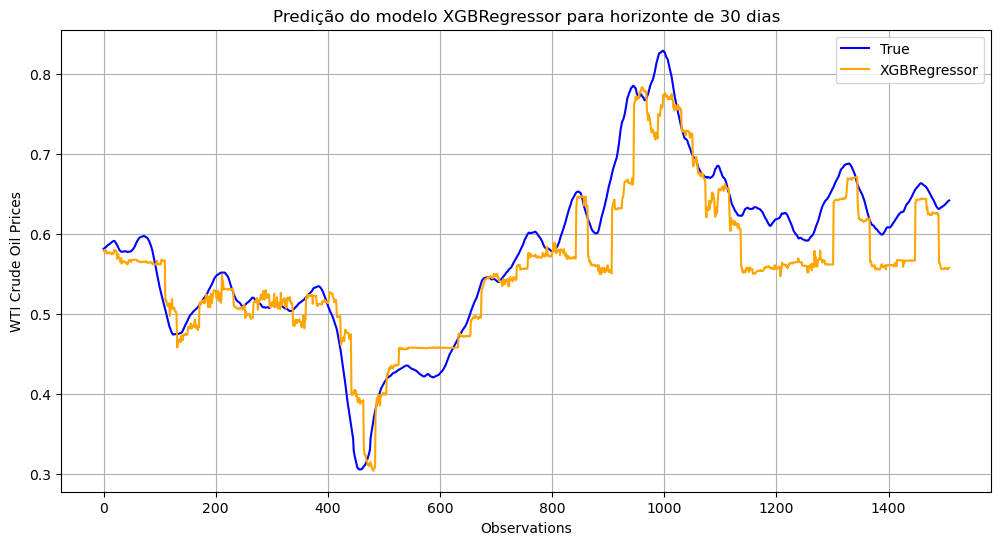

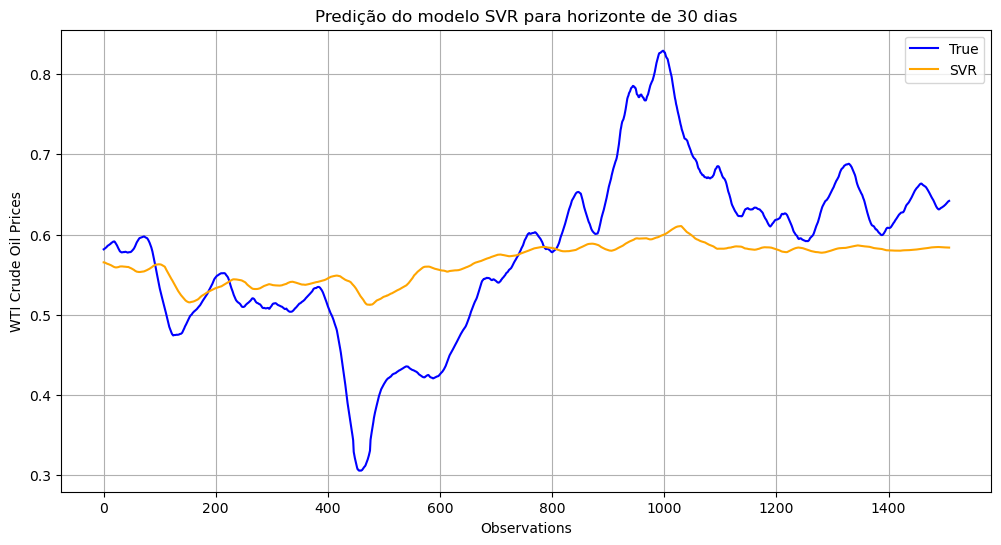

In [28]:
# Plotar previsões vs valores reais para cada modelo e horizonte
for horizon in horizons:
    for name in model_names:
        y_test = split_data_dict[horizon][3]  # y_test é o quarto elemento da tupla retornada por train_test_split
        y_pred = results[name][horizon]["y_pred"]
        plot_predictions(y_test, y_pred, name, horizon)

Ainda não descobri o erro, mas há uma clara diferença nos gráficos dos horizontes h=1 para h=30, por exemplo. No 1º caso parece que estamos a prever os preços do WTI e no h=30 parece que o modelo está a usar a variável monthly_avg_price. 

Ao usar a variável monthly_avg_price temos uma linha diferente, já que durante os dias úteis de cada mês o valor será sempre igual. 

# Previsão vs Real

## Linear Regression, h=1

In [170]:
# Now, plot only the Linear Regression results for horizon h=1
horizon = 1
model_name = "Linear Regression"

In [171]:
# Extract the specific y_test and y_pred for this model and horizon
y_test = split_data_dict[horizon][3]  # y_test é o quarto elemento da tupla retornada por train_test_split
y_pred = results[model_name][horizon]["y_pred"]

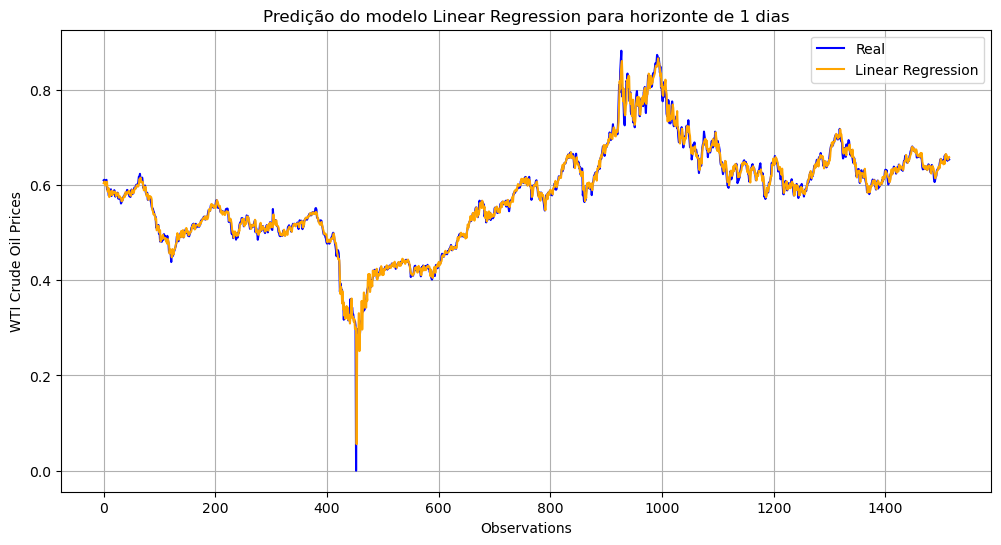

In [172]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Real', color='blue')
plt.plot(range(len(y_test)), y_pred, label='Linear Regression', color='orange')
plt.title(f'Predição do modelo {model_name} para horizonte de {horizon} dias')
plt.xlabel('Observations')
plt.ylabel('WTI Crude Oil Prices')
plt.legend()
plt.grid(True)
plt.show()

## Primeiras observações

In [187]:
# Filtrar apenas as primeiras 50 observações
max_observations = 50
y_test_subset = y_test[:max_observations]
y_pred_subset = y_pred[:max_observations]

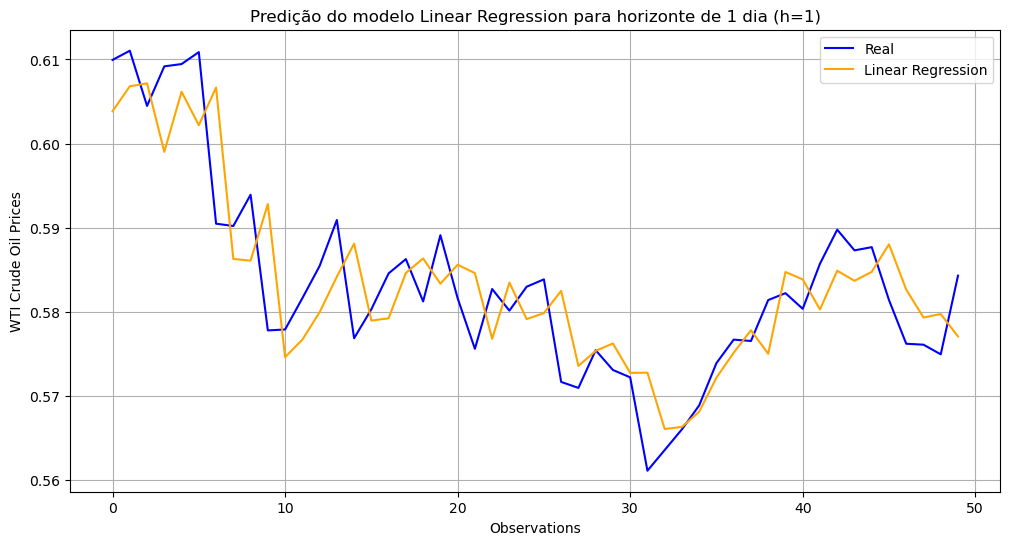

In [176]:
# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_subset)), y_test_subset, label='Real', color='blue')
plt.plot(range(len(y_test_subset)), y_pred_subset, label='Linear Regression', color='orange')
plt.title(f'Predição do modelo Linear Regression para horizonte de 1 dia (h=1)')
plt.xlabel('Observations')
plt.ylabel('WTI Crude Oil Prices')
plt.legend()
plt.grid(True)
plt.show()

## Janeiro 2023

In [182]:
# Assuming that 'filtered_data' contains the original dates
# Extract the dates corresponding to the test set (20% of the data)
test_dates = filtered_data.index[-len(X_test):]

In [183]:
# Define the January 2023 date range
january_2023_start = pd.to_datetime('2023-01-01')
january_2023_end = pd.to_datetime('2023-01-31')

In [184]:
# Create a boolean mask for January 2023
january_indices = (test_dates >= january_2023_start) & (test_dates <= january_2023_end)


In [185]:
# Filter the y_test and y_pred arrays using these indices
y_test_january_2023 = y_test[january_indices]
y_pred_january_2023 = y_pred[january_indices]

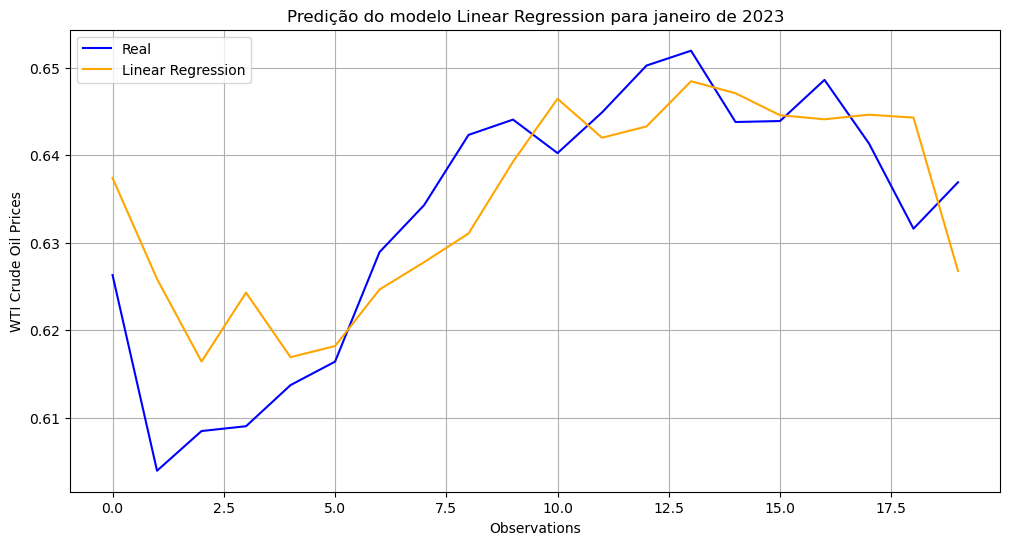

In [186]:
# Plot the results for January 2023
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_january_2023)), y_test_january_2023, label='Real', color='blue')
plt.plot(range(len(y_test_january_2023)), y_pred_january_2023, label='Linear Regression', color='orange')
plt.title(f'Predição do modelo Linear Regression para janeiro de 2023')
plt.xlabel('Observations')
plt.ylabel('WTI Crude Oil Prices')
plt.legend()
plt.grid(True)
plt.show()

### Eixo x com n.os inteiros

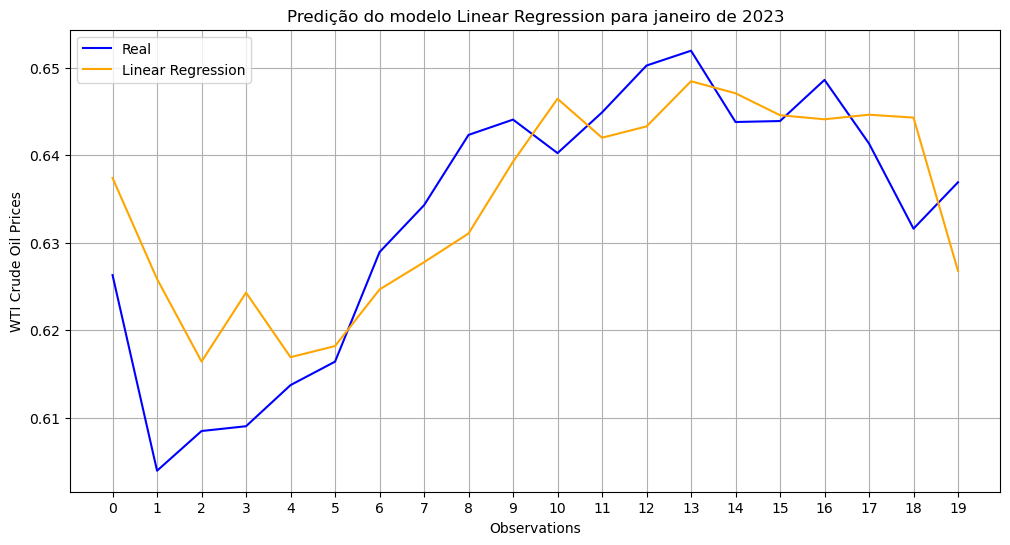

In [188]:
# Plotar os resultados corrigindo o eixo x para números inteiros
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_january_2023)), y_test_january_2023, label='Real', color='blue')
plt.plot(range(len(y_test_january_2023)), y_pred_january_2023, label='Linear Regression', color='orange')
plt.title(f'Predição do modelo Linear Regression para janeiro de 2023')
plt.xlabel('Observations')
plt.ylabel('WTI Crude Oil Prices')
plt.xticks(np.arange(0, len(y_test_january_2023), step=1))  # Ajustar o eixo x para números inteiros
plt.legend()
plt.grid(True)
plt.show()

Através deste exemplo em que temos 19 observações referentes ao mês de janeiro de 2023, que correspondem aos dias úteis, podemos concluir que o modelo de previsão usou como variável dependente os preços do WTI Crude Oil e está a fazer a previsão diária do preço do WTI Crude Oil em vez de prever a média das cotações, portanto, o código terá de ser alterado e reformulado, para que seja possível comparar os resultados reais com os resultados previstos. 

O objetivo será usar 12 observações, referentes à penúltima 4f de cada mês, já que é um momento decisivo de aquisição de combustível e perceber se usando essa previsão seria possível adquirir mais combustível com o mesmo orçamento.

In [193]:
# Extract the first 20 values of real and predicted results for Linear Regression with h=1
horizon = 1
model_name = "Linear Regression"
y_test = split_data_dict[horizon][3]  # y_test é o quarto elemento da tupla retornada por train_test_split
y_pred = results[model_name][horizon]["y_pred"]